# Graph embedding using CBOW
[The CBOW model](https://arxiv.org/pdf/1606.04640.pdf) predicts the central word given the context words.

In our implementatation, as for both the Binary SkipGram model and the SkipGram model, since the batches walks are lazily generated, the memory requirements are minimal and the method can scale to very big graphs. It can also run on graphs like Monarch (150M edges and 50M nodes) provided that you use a GPU ([or better still a TPU](https://cloud.google.com/ai-platform/training/docs/using-tpus#console)) that is able to fit an embedding model that big, but that is just related to the shear number of nodes.

In [1]:
import silence_tensorflow.auto # Import needed to avoid TensorFlow warnings and general useless infos.

## Loading the graphs
We load the ppi graph from the repository as a weighted undirected graph.

To load the graph we are using the sister package of Embiggen called [Ensmallen](https://github.com/LucaCappelletti94/ensmallen_graph). Ensmallen is a Rust library with python bindings to handle processing of graph files and preprocessing of data for quickly training embedding models.

It also supports numerous utilities that can be helpful when dealing with graphs, such as ways to compute holdouts of different kinds on the graph edges.

In [2]:
from ensmallen_graph import EnsmallenGraph

graph = EnsmallenGraph.from_csv(
    edge_path="../data/ppi/edges.tsv",
    sources_column="subject",
    destinations_column="object",
    directed=False,
    weights_column="weight"
)

As first thing, we print a short report showing all the avalable graph details, including the number of edges, nodes, trap nodes and both the connected components and the strongly connected components.

In [3]:
graph.report()

{'unique_node_types_number': '0',
 'unique_edge_types_number': '0',
 'degrees_median': '11',
 'edges_number': '588748',
 'density': '0.001993564869255138',
 'is_directed': 'false',
 'selfloops_percentage': '0',
 'strongly_connected_components_number': '181',
 'nodes_number': '17185',
 'traps_rate': '0',
 'singleton_nodes': '0',
 'degrees_mode': '1',
 'degrees_mean': '34.25941227814955',
 'bidirectional_percentage': '1',
 'connected_components_number': '181'}

## Creating the training and validation partitions
To execute the embedding of the graph with the goal of running Link Prediction on the obtained vectors (after having obtained the edges embeddings from the nodes embeddings), we need to create two partitions of the graph. One containing the training set edges, which is left connected (if the initial graph was connected) or at least with the same number of connected components are the initial graph, and one containing the validation set edges, which may not be connected.

The requirement for connectivity is stated in the seminal work from [Leskovec et al.](https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf) but we have no proofs, currently, that actually changes performance of the embedding.

#### Limitation in using connected training set
Creating holdouts in this fashion allows us to estimate the real-world model performance only for cases when the new edges that we intend to predict are part of the existing graph components and do not ever connect separated components of the graph.

### Why not simply using the complete graph in the embedding process
If we were to use the complete graph during the embedding process, we would end up encoding the answers for the Link Prediction problem into the embedding for both the training and validation partitions, hence adding a positive bias that would inflate the performance of the models.

**NB: the entire graph should be used for embeddings when the task will be a node-label prediction task, when no nodes labels are taken in consideration in any shape of form during the random walks.**

### The inevitable presence of false negatives in the embedding training process

In the training set of the model there will be inevitably some false negatives. These originates from the sampling of random edges as negatives.

In Binary SkipGram, meaning the models that receive two words and tries to predict if the connection exists or not, this sampling is needed to produce negative examples so that the network don't overfit returning always true.

In Categorical-Models, such as CBOW and non-binary SkipGram, meaning the one which either receive the context and tries to predict the central word, or receives the word and tries to predict the context, the sample is only present if they use the [Noise Contrastive Estimation (NCE)](https://www.tensorflow.org/api_docs/python/tf/nn/nce_loss) loss which, instead of computing the softmax and the categorical cross entropy, samples a random number of categories per batch and applies, to the choosen outputs, a sigmoid activation function, hence computing the logits, and then computes the binary cross-entropy for each of them. Finally the losses are summed to obtain the final loss.

In this case, the problem of false negatives araise from the fact that during the computation of the NCE loss, in order to have negative examples, the function samples random words to use as wrong predictions for the given context. This of course could create false negatives if the choosen random word appears in another batch with the same context, and can be easily shown that this leads to sampling potentialy false negative edges.

The only method to avoid these is to do the **embedding on the whole graph** which create a positive bias for the link-prediction.
This bias is formed because the embedding is encoding the data by learning which nodes are close and **thus is encoding the link prediction of the validation set and invalidating the link-prediction performances**.

Therefore, the only way is to accept the false negatives since in a real world application the link prediction is used as an oracle to explore new possible edges. 

#### Additional false positives relative to collisions with known training edges
For the same sampling issue, there will be also collisions with the training edges. This should be a lesser problem though, as the model will be more likely to see the positive label for any given training edge that the collision, though to the strong imbalance between the number of available training edges and the complete number of edges.

This imbalance, in PPI, is around 1 positive edge to 1000 negative edges.

### Early stopping criterion for the embedding process
For the early stopping criterion used in the embedding process, during the model selection (the procedure where we select the optimal $p$, $q$ and embedding size parameters, amongs others) we can use the validation partition to stop the training early (hence early stopping) when a metric representing of the quality of the embedding stops improving.

Since the validation set is not connected we cannot diretly use the validation set for th early stopping, as it would not allow us to create random walks that represent the graph structure.

For this reason we need to use the entire training+validation set for the early stopping. This will allow us to compute random walks that should be representative of the graph structure.

The validation edges are never fed into the training model as positives, but are only used in the context of the early stopping.

### Splitting the graph into the two edge partitions
As described above, we split the graphs into two partitions:

- The training component, with the same number of components as the initial graph
- The validation component, that may have more components than the initial graph

In [4]:
training, validation = graph.connected_holdout(42, 0.8)

The followings are check that are not necessary, but are offered as sanity checks:

In [5]:
assert graph > training
assert graph > validation
assert (training + validation).contains(graph)
assert graph.contains(training + validation)
assert not training.overlaps(validation)
assert not validation.overlaps(training)

### Considered parameters
We are going to use the following parameters:

- **Walk lengths:** $100$ nodes.
- **Batch size:** $2^{7} = 128$ walks per batch.
- **Walk iterations:** $20$ iterations on the graph.
- **Window size:** $4$ nodes, meaning $4$ on the left and $4$ on the right of the center nodes. Consider that the first *window_size* values on the left and the right of the walks will be trimmed.
- **Return weight, inverse of $p$:** $1.0$.
- **Explore weight, inverse of $q$:** $1.0$.
- **Embedding size:** $100$.
- **Negative samples:** For the porpose of the [NCE function negative samples](https://www.tensorflow.org/api_docs/python/tf/nn/nce_loss), we are going to use $10$. These are the number of negative classes to randomly sample per batch. This single sample of negative classes is evaluated for each element in the batch.
- **Optimizer:** [Nadam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Nadam).
- **Early stopping parameters:** We are going to use an Early Stopping criterion on the *validation loss*, with patience $5$ and delta $0.0001$.
- **Epochs:** The model will be trained up to $1000$ epochs.
- **Learning rate:** since tipically the loss function is quite convex for the embedding problem, we can use a relatively higher learning rate. We are going to us $0.1$ for this example, to get to a faster convergence: this might lead to skipping some better minima that might be identified with a lower learning rate, such as the default one which is $0.0001$.

#### Setting up the parameters

In [6]:
walk_length=100
batch_size=2**7
iterations=20
window_size=4
p=1.0
q=1.0
embedding_size=100
negative_samples=2
patience=5
delta=0.0001
epochs=1000
learning_rate=0.1

#### Creating the training and validation Keras sequences

In [7]:
from embiggen import Node2VecSequence

training_sequence = Node2VecSequence(
    training,
    length=walk_length,
    batch_size=batch_size,
    iterations=iterations,
    window_size=window_size,
    return_weight=1/p,
    explore_weight=1/q
)

validation_sequence = Node2VecSequence(
    graph, # Here we use the entire graph. This will only be used for the early stopping.
    length=walk_length,
    batch_size=batch_size,
    iterations=iterations,
    window_size=window_size,
    return_weight=1/p,
    explore_weight=1/q
)

## Creating the CBOW model
We are going to setup the model to use, if available, multiple GPUs.

In [8]:
from tensorflow.distribute import MirroredStrategy
from tensorflow.keras.optimizers import Nadam
from embiggen import CBOW

strategy = MirroredStrategy()
with strategy.scope():
    model = CBOW(
        vocabulary_size=training.get_nodes_number(),
        embedding_size=embedding_size,
        window_size=window_size,
        negative_samples=negative_samples,
        optimizer=Nadam(learning_rate=learning_rate)
    )

model.summary()

Model: "CBOW"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words_embedding (InputLayer)    [(None, 8)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 8, 100)       1718500     words_embedding[0][0]            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 100)          0           embedding[0][0]                  
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 1)]          0                                            
_______________________________________________________________________________________________

## Tuning the CBOW model

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

history = model.fit(
    training_sequence,
    steps_per_epoch=training_sequence.steps_per_epoch,
    validation_data=validation_sequence,
    validation_steps=validation_sequence.steps_per_epoch,
    epochs=1000,
    callbacks=[
        EarlyStopping(
            "val_loss",
            min_delta=delta,
            patience=patience,
            restore_best_weights=True
        )
    ]
)

Epoch 1/1000
135/135 [==============================] - 48s 357ms/step - loss: 22.3277 - val_loss: 20.3261
Epoch 2/1000
135/135 [==============================] - 47s 345ms/step - loss: 19.3855 - val_loss: 18.5955
Epoch 3/1000
135/135 [==============================] - 47s 345ms/step - loss: 17.6078 - val_loss: 15.0310
Epoch 4/1000
135/135 [==============================] - 46s 344ms/step - loss: 16.1644 - val_loss: 16.0042
Epoch 5/1000
135/135 [==============================] - 47s 345ms/step - loss: 14.3992 - val_loss: 14.6035
Epoch 6/1000
135/135 [==============================] - 47s 345ms/step - loss: 15.0524 - val_loss: 12.8769
Epoch 7/1000
135/135 [==============================] - 46s 344ms/step - loss: 13.6048 - val_loss: 13.6034
Epoch 8/1000
135/135 [==============================] - 47s 345ms/step - loss: 12.3297 - val_loss: 12.2957
Epoch 9/1000
135/135 [==============================] - 46s 344ms/step - loss: 11.2956 - val_loss: 12.5203
Epoch 10/1000
135/135 [==============

### Saving the model weights
We save the obtained model weights:

In [10]:
model.save_weights(f"{model.name}_weights.h5")

### Visualizing the training history
We can visualize the performance of the model during the training process as follows:

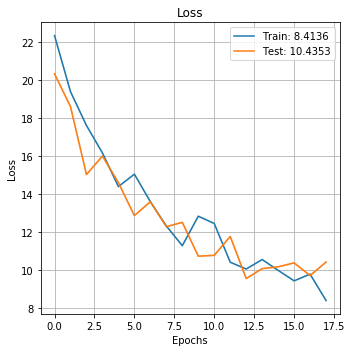

In [11]:
from plot_keras_history import plot_history

plot_history(history)

There may be some hickups in the plot of the history if the model is reloaded from stored weights: [this is a known Keras issue](https://github.com/keras-team/keras/issues/4875) and is not related to either the holdouts used or the model.

## Saving the obtained embeddings
Finally we save our hard earned model embeddings. In another notebook we will show how to do link prediction on the obtained embedding.

In [12]:
import numpy as np

np.save(f"{model.name}_embedding.npy", model.embedding)